<a href="https://colab.research.google.com/github/sanzidarahman1/ENGG_680_Project/blob/main/LSTM_EB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
file_path = 'train and validation_EB.xlsx'
data = pd.read_excel(file_path)

# Step 1: Data Inspection
print("First few rows of the dataset:")
print(data.head())
print("\nDataset info:")
print(data.info())

# Step 2: Check for Missing Values
missing_values = data.isnull().sum()
print("\nMissing values summary:")
print(missing_values)

# Step 3: Convert 'date' and 'time' to appropriate formats
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.time

# Step 4: Encode categorical variables
data['weekend/holiday (y/n)'] = data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
data['stampede (y/n)'] = data['stampede (y/n)'].map({'y': 1, 'n': 0})
data = pd.get_dummies(data, columns=['Day_Type'], prefix='DayType')

# Step 5: Inspect cleaned data
print("\nCleaned dataset:")
print(data.head())

# Step 6: Feature Selection and Scaling
features = ['vehicle count', 'temp. (C)', 'daily precip. (mm)', 'wind (km/h)',
            'weekend/holiday (y/n)', 'stampede (y/n)'] + [col for col in data.columns if 'DayType_' in col]
target = 'vehicle count'

# Filter features
data_features = data[features]

# Initialize MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_features)
data_scaled_df = pd.DataFrame(data_scaled, columns=features)

# Step 7: Create Sequences for LSTM
sequence_length = 24  # 24-hour sequences
X, y = [], []

for i in range(sequence_length, len(data_scaled_df)):
    X.append(data_scaled_df.iloc[i-sequence_length:i].values)
    y.append(data_scaled_df.iloc[i][data_features.columns.get_loc(target)])

# Convert to NumPy arrays
X, y = np.array(X), np.array(y)

# Step 8: Verify Shapes
print("\nShape of input data (X):", X.shape)
print("Shape of target data (y):", y.shape)

# Step 9: Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print("\nTraining data shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nValidation data shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

# Ready for LSTM Modeling


First few rows of the dataset:
        date      time  vehicle count weekend/holiday (y/n) stampede (y/n)  \
0 2023-08-01  00:00:00             29                     n              n   
1 2023-08-01  00:15:00             31                     n              n   
2 2023-08-01  00:30:00             32                     n              n   
3 2023-08-01  00:45:00             15                     n              n   
4 2023-08-01  01:00:00             13                     n              n   

   temp. (C)  daily precip. (mm)  wind (km/h) Day_Type  
0       12.8                 0.0           10    Sunny  
1       12.8                 0.0           10    Sunny  
2       12.8                 0.0           10    Sunny  
3       12.8                 0.0           10    Sunny  
4       12.0                 0.0            7    Sunny  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29280 entries, 0 to 29279
Data columns (total 9 columns):
 #   Column                 Non-Nul

<ipython-input-3-ad91d2151bb8>:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data_scaled_df.iloc[i][data_features.columns.get_loc(target)])



Shape of input data (X): (29256, 24, 9)
Shape of target data (y): (29256,)

Training data shapes:
X_train: (23404, 24, 9)
y_train: (23404,)

Validation data shapes:
X_val: (5852, 24, 9)
y_val: (5852,)



Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 64)              │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 0.0155 - mae: 0.0845 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0022 - mae: 0.0350 - val_loss: 0.0011 - val_mae: 0.0239
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - loss: 0.0017 - mae: 0.0302 - val_loss: 9.4624e-04 - val_mae: 0.0222
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - loss: 0.0015 - mae: 0.0288 - val_loss: 9.3096e-04 - val_mae: 0.0218
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 9.5933e-04 - val_mae: 0.0222
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 8.3420e-04 - val_mae: 0.0207
Epoch 7/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 8.7386e-04 - val_mae: 0.0209
Epoch 8/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 7.6494e-04 - val_mae: 0.0197
Epoch 9/50
732/7

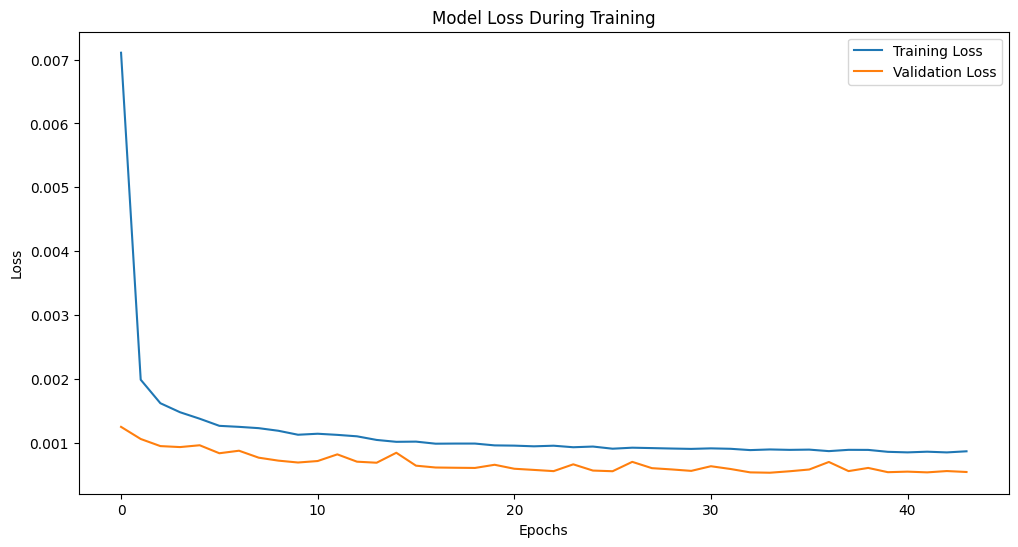


Training Loss: 0.0005, Training MAE: 0.0167
Validation Loss: 0.0005, Validation MAE: 0.0166
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


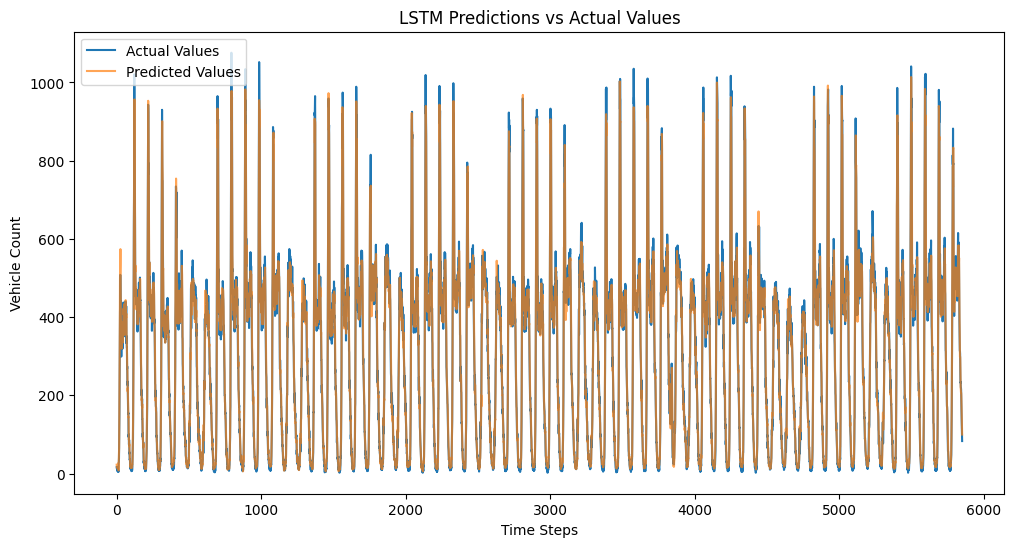

Model saved successfully!
Predictions saved successfully to predictions.csv!


In [ ]:
# Import required libraries for the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 10: Build the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
print("\nModel Summary:")
model.summary()

# Step 11: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 12: Visualize Training Performance
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 13: Evaluate the Model
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

print(f"\nTraining Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

# Step 14: Make Predictions
y_pred = model.predict(X_val)

# Reverse Scaling to Get Actual Predictions
y_val_actual = scaler.inverse_transform(data_scaled[-len(y_val):])[:, features.index(target)]
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], len(features) - 1)))))[:, features.index(target)]

# Step 15: Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_val_actual, label='Actual Values')
plt.plot(y_pred_actual, label='Predicted Values', alpha=0.7)
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Vehicle Count')
plt.legend()
plt.show()

# Step 16: Save the Model
model.save('/mnt/data/lstm_traffic_model.h5')
print("Model saved successfully!")

# Step 17: Save Results to CSV (optional)
results = pd.DataFrame({'Actual': y_val_actual, 'Predicted': y_pred_actual})
results.to_csv('/mnt/data/predictions.csv', index=False)
print("Predictions saved successfully to predictions.csv!")


In [ ]:
import os
print(os.getcwd())  # This will print the current working directory

/content


In [ ]:
# Step 16: Save the Model
model.save('lstm_traffic_model.h5')
print("Model saved successfully!")

# Step 17: Save Results to CSV (optional)
results = pd.DataFrame({'Actual': y_val_actual, 'Predicted': y_pred_actual})
results.to_csv('predictions.csv', index=False)
print("Predictions saved successfully to predictions.csv!")

Model saved successfully!
Predictions saved successfully to predictions.csv!


Mean Absolute Error (MAE): 21.972777815231378
Root Mean Squared Error (RMSE): 30.4349081046438
R-Squared (R²): 0.9829682645728328


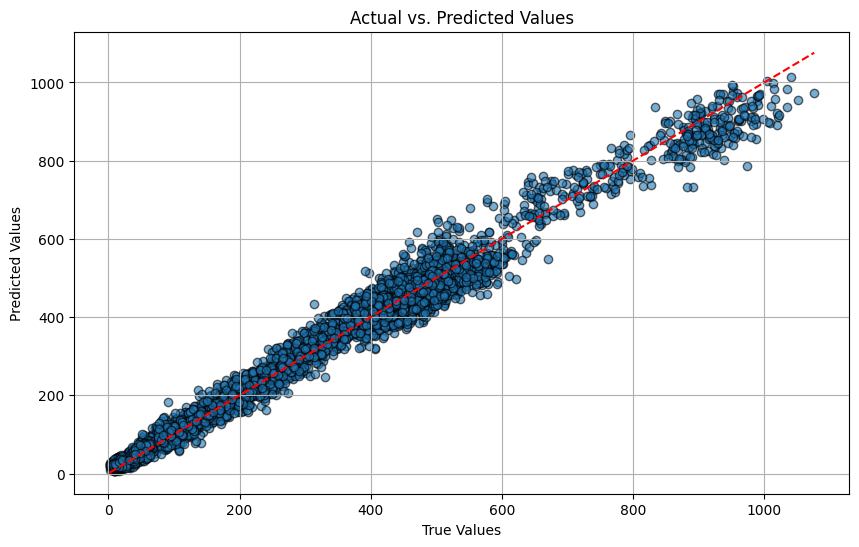

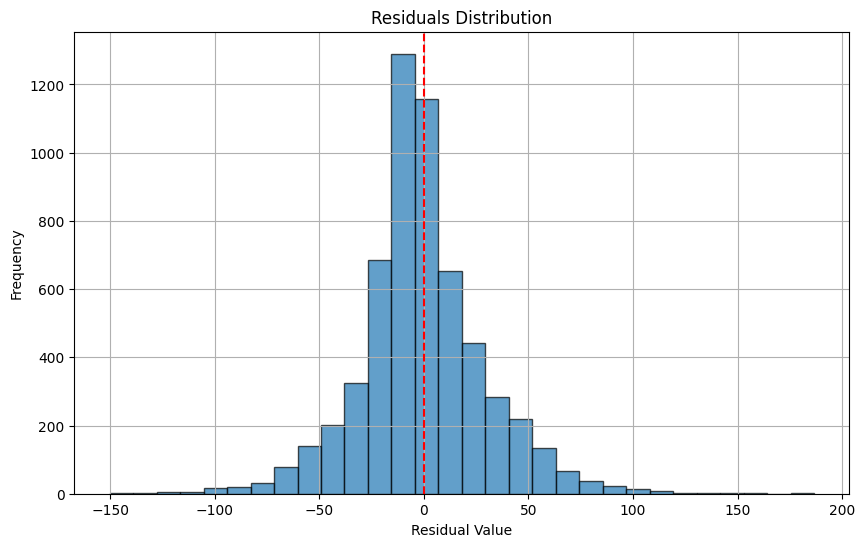

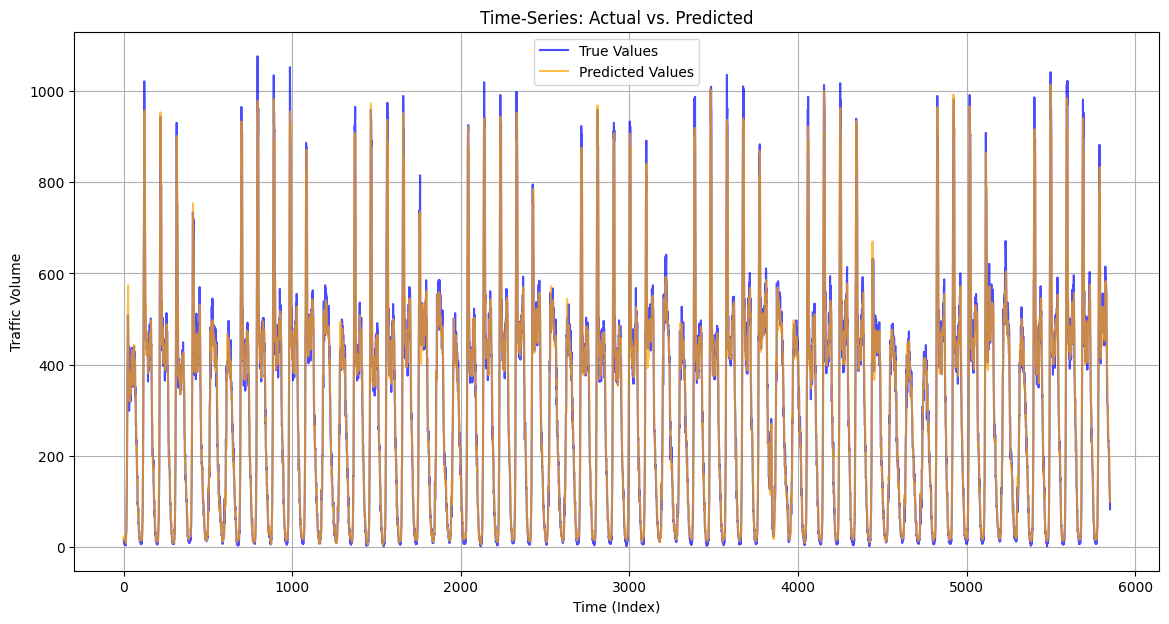


--- Insights ---
1. High R² and alignment between actual and predicted values indicate good model performance.
2. Outliers in residuals suggest cases where the model may require more training or data preprocessing.

--- Recommendations ---
1. Investigate outliers in residuals for potential data inconsistencies.
2. Consider additional feature engineering to capture complex patterns.
3. Increase model complexity or try alternative models (e.g., GRU or advanced transformers).


In [8]:
# Import necessary libraries for analysis
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load predictions and true values
predictions = pd.read_csv('predictions.csv')
true_values = predictions['Actual']
predicted_values = predictions['Predicted']

# Statistical Analysis
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
r2 = r2_score(true_values, predicted_values)

# Print Metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared (R²): {r2}")

# Visualization: Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predicted_values, alpha=0.6, edgecolors='k')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r', linestyle='--')
plt.title("Actual vs. Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residual Analysis
residuals = true_values - predicted_values
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.axvline(0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Time-Series Trends
plt.figure(figsize=(14, 7))
plt.plot(true_values, label="True Values", color='blue', alpha=0.7)
plt.plot(predicted_values, label="Predicted Values", color='orange', alpha=0.7)
plt.title("Time-Series: Actual vs. Predicted")
plt.xlabel("Time (Index)")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

# Insights and Recommendations
print("\n--- Insights ---")
print("1. High R² and alignment between actual and predicted values indicate good model performance.")
print("2. Outliers in residuals suggest cases where the model may require more training or data preprocessing.")
print("\n--- Recommendations ---")
print("1. Investigate outliers in residuals for potential data inconsistencies.")
print("2. Consider additional feature engineering to capture complex patterns.")
print("3. Increase model complexity or try alternative models (e.g., GRU or advanced transformers).")
